# BooksNN - Tensorflow Feedforward Neural Network

Try a the most basic feedforward neural network. Plenty of room for improvement. This would also improve substantially from more ASINs. 500 is not enough - want tens of thousands.


A temporal convolutional neural network (TCNN) will likely do great here. 


Conclusion: the basic trend is captured. Details are not. 


## Predict price 6 months out 

*Inputs:* 2 years of used price, sales rank and used count data. 

*Outputs:* 6 months of used price data, weekly. 

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyisbn #module for converting ISBN-13 to ISBN-10 and vice versa
import booksnn as bnn
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



2.4.0
Num GPUs Available:  1


In [2]:
asins_in_db = bnn.get_asin_list()
print('Total number of ASINs in database: ' + str(len(asins_in_db)))

#asins = asins_in_db[0:10] #select a subset if desired
#print('Total number of ASINs selected: ' + str(len(asins))+'\n')


Total number of ASINs in database: 577


In [3]:
# Load data in time range
X = []
y = []

# there's an error if the start date is too far back due to some list in the process being empty.
series_date_range = pd.date_range('2016-01-01', '2017-01-01').tolist()

for d in tqdm(series_date_range):
    startdate = d.strftime('%Y-%m-%d')
    splitdate = d + pd.DateOffset(days=365*2)
    splitdate = splitdate.strftime('%Y-%m-%d')
    enddate = d + pd.DateOffset(days=365*2+180)
    enddate = enddate.strftime('%Y-%m-%d')
    #print(startdate, end=',')
    #print(splitdate, end=',')
    #print(enddate, end=',')
    X_series,y_series =  bnn.load_data(num_asins='all', #could be 'all'
                                       sample_interval = 'D',
                                       startdate = startdate,
                                       enddate = enddate,
                                       splitdate = splitdate,
                                       verbose=0)
    X.append(X_series)
    y.append(y_series[:,0:180])
    
X = np.concatenate(X,axis=0)
y = np.concatenate(y,axis=0)

# Replace possible nan's with zeros (how do nan's get there?!?)
X = np.nan_to_num(X)
y = np.nan_to_num(y)

100%|██████████| 367/367 [1:38:39<00:00, 16.13s/it]


In [15]:

import pickle
pickle.dump( X, open( "X.p", "wb" ) )
pickle.dump( y, open( "y.p", "wb" ) )
 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#Create Tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

#THIS SHOULD BE FROM A SEPARATE POPULATION OF ASINS
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(153572, 2190)
(153572, 180)
(17064, 2190)
(17064, 180)


In [6]:
# Are there NaNs in the data?
# Replace possible nan's with zeros (how do nan's get there?!?)
X = np.nan_to_num(X)
y = np.nan_to_num(y)

In [23]:
# Build model
inputs = keras.Input(shape=(2190,), name="inputs")
x = layers.Dense(2**10, activation = 'tanh', name="dense_1")(inputs)
x = layers.Dense(2**9, activation = 'tanh', name="dense_2")(x)
x = layers.Dense(2**8, activation = 'tanh', name="dense_3")(x)
outputs = layers.Dense(180, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


"\nmodel.compile(optimizer='adam',\n              loss='mean_squared_error',\n              metrics=['RootMeanSquaredError'])\n\nmodel.summary()\n"

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2190)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2243584   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
predictions (Dense)          (None, 180)               46260     
Total params: 2,552,244
Trainable params: 2,552,244
Non-trainable params: 0
_________________________________________________________________


In [24]:
#history = model.fit(dataset)#,epochs=100)#,verbose=1)
model.compile('adam', #optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001)
              loss='mean_squared_error',
              metrics=['RootMeanSquaredError'])

In [31]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    #validation_data=(x_val, y_val),
)

Epoch 1/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1614 - root_mean_squared_error: 0.4017
Epoch 2/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1613 - root_mean_squared_error: 0.4016
Epoch 3/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020
Epoch 4/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1614 - root_mean_squared_error: 0.4018
Epoch 5/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020
Epoch 6/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1617 - root_mean_squared_error: 0.4022
Epoch 7/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020
Epoch 8/10
2400/2400 [==============================] - 3s 1ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020
Epoch 9/10
2400/2400 [==============================] - 4s 2ms/s

In [33]:
pred = model.predict(X_test)

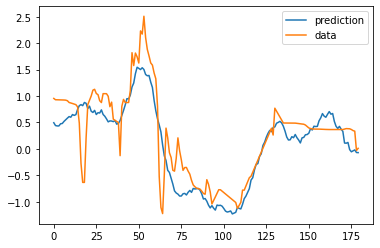

In [34]:
num=10
plt.plot(pred[num,:])
plt.plot(y_test[num,:])
plt.legend(['prediction','data'])
plt.show()

##### X.shape

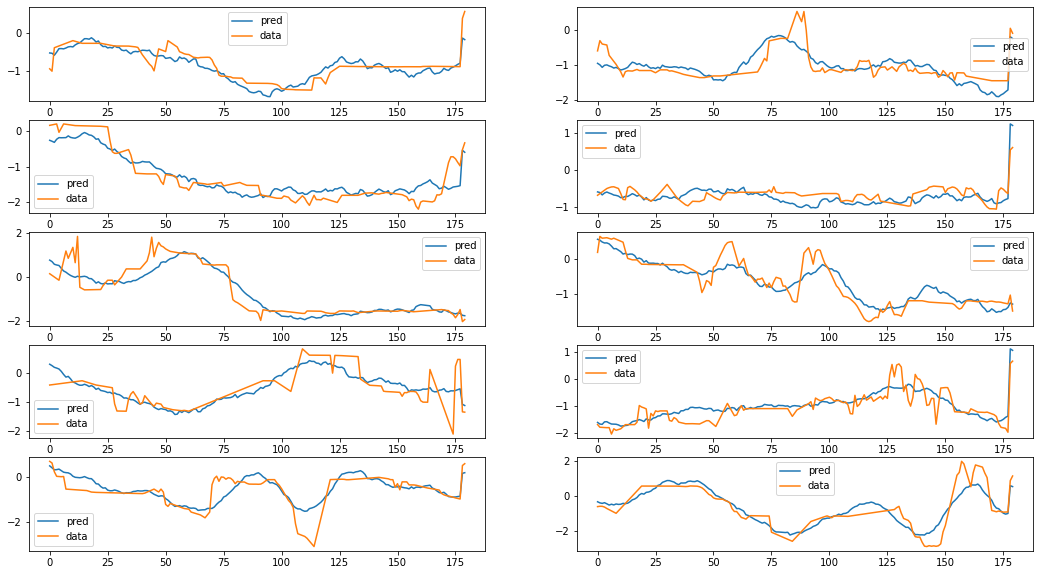

In [40]:
num_plots = 10

offset=40

f, axs = plt.subplots(5,2,figsize=(18,10))#,figsize = (18,4*len(X_test[0])))

for i in range(0,10):
    axs[i%5,i%2].plot(pred[i+offset,:])
    axs[i%5,i%2].plot(y_test[i+offset,:])
    axs[i%5,i%2].legend(['pred','data'])
    